# Modeling KMeans, KAgglomerativeClustering, Annoy

## Imports

In [ ]:
pip install --user annoy

In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
from tqdm import tqdm
import pickle as pkl
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from annoy import AnnoyIndex
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans # import from sklearn
from scipy.cluster.hierarchy import dendrogram, ward, single, complete, average
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

## Pickle Load and Helper Functions

In [3]:
df_for_brands = pkl.load(open('df_pickles/df_reg_1.p','rb'))

In [4]:
df_for_brands.drop('price',1,inplace=True)

In [5]:
df_for_brands_gas = df_for_brands[df_for_brands['Engine type']!='Electric']

In [6]:
df_for_brands_elec = df_for_brands[df_for_brands['Engine type']=='Electric']

In [7]:
prices = pkl.load(open('df_pickles/prices.p','rb'))

In [8]:
df_for_brands_gas = pd.concat([df_for_brands_gas, prices],1)

In [9]:
## GAS ##

In [10]:
df_gas = pkl.load(open('df_pickles/df_gas_sc_dmd.p','rb'))

In [11]:
df_gas_mod = df_gas.drop(['model', 'front_suspension_type_1',
       'front_suspension_type_2', 'front_suspension_type_3',
       'front_suspension_type_4', 'front_suspension_type_5',
       'front_suspension_type_6', 'front_suspension_type_7',
       'front_suspension_type_8', 'front_suspension_type_9', 
        'front_suspension_type_10', 'front_suspension_type_11',
       'front_suspension_type_12', 'front_wheel_diameter_15',
       'front_wheel_diameter_16', 'front_wheel_diameter_17',
       'front_wheel_diameter_18', 'front_wheel_diameter_19',
       'front_wheel_diameter_20', 'front_wheel_diameter_21',
       'front_wheel_diameter_22', 'rear_suspension_type_1',
       'rear_suspension_type_2', 'rear_suspension_type_3',
       'rear_suspension_type_4', 'rear_suspension_type_5', 
                          'rear_suspension_type_6',
       'rear_suspension_type_7', 'rear_suspension_type_8',
       'rear_suspension_type_9', 'rear_suspension_type_10',
       'rear_wheel_diameter_15', 'rear_wheel_diameter_16',
       'rear_wheel_diameter_17', 'rear_wheel_diameter_18',
       'rear_wheel_diameter_19', 'rear_wheel_diameter_20',
       'rear_wheel_diameter_21', 'rear_wheel_diameter_22',
                         'brand_1',
       'brand_2', 'brand_3', 'brand_4', 'brand_5', 'brand_6', 'brand_7',
       'brand_8', 'brand_9', 'brand_10', 'brand_11', 'brand_12', 'brand_13',
       'brand_14', 'brand_15', 'brand_16', 'brand_17', 'brand_18', 'brand_19',
       'brand_20', 'brand_21', 'brand_22', 'brand_23', 'brand_24', 'brand_25',
       'brand_26', 'brand_27', 'brand_28', 'brand_29', 'brand_30', 'brand_31',
       'brand_32', 'brand_33', 'brand_34', 'brand_35', 'brand_36', 'brand_37',
       'brand_39', 'brand_40', 'brand_41'], 1)

In [12]:
## ELEC

In [13]:
df_elec = pkl.load(open('df_pickles/df_elec_sc_dmd.p','rb'))

In [14]:
df_elec.columns[20:];

In [15]:
df_elec_mod = df_elec.drop(['model', 'front_suspension_type_6', 'front_suspension_type_354',
       'front_suspension_type_382', 'front_suspension_type_443',
       'front_suspension_type_485', 'front_suspension_type_486',
       'front_suspension_type_487', 'front_suspension_type_687',
       'front_suspension_type_1013', 'front_wheel_diameter_16.0',
       'front_wheel_diameter_17.0', 'front_wheel_diameter_18.0',
       'front_wheel_diameter_19.0', 'front_wheel_diameter_20.0',
       'front_wheel_diameter_354.0', 'front_wheel_diameter_382.0',
       'front_wheel_diameter_443.0', 'front_wheel_diameter_485.0',
       'front_wheel_diameter_486.0', 'front_wheel_diameter_487.0',
       'front_wheel_diameter_687.0', 'front_wheel_diameter_1013.0',
       'rear_suspension_type_6', 'rear_suspension_type_9',
       'rear_suspension_type_354', 'rear_suspension_type_382',
       'rear_suspension_type_443', 'rear_suspension_type_485',
       'rear_suspension_type_486', 'rear_suspension_type_487',
       'rear_suspension_type_687', 'rear_suspension_type_1013',
       'rear_wheel_diameter_16.0', 'rear_wheel_diameter_17.0',
       'rear_wheel_diameter_18.0', 'rear_wheel_diameter_19.0',
       'rear_wheel_diameter_20.0', 'rear_wheel_diameter_354.0',
       'rear_wheel_diameter_382.0', 'rear_wheel_diameter_443.0',
       'rear_wheel_diameter_485.0', 'rear_wheel_diameter_486.0',
       'rear_wheel_diameter_487.0', 'rear_wheel_diameter_687.0',
       'rear_wheel_diameter_1013.0', 'brand_11', 'brand_16', 'brand_17',
       'brand_19', 'brand_21', 'brand_33', 'brand_38', 'brand_39', 'brand_40',
       'brand_42', 'brand_354', 'brand_382', 'brand_443', 'brand_485',
       'brand_486', 'brand_487', 'brand_687', 'brand_1013'], 1)

In [16]:
df_gas_mod.columns;

In [17]:
def threed_figures(model, df):
    fignum = 1
    fig = plt.figure(fignum, figsize=(20, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = model.labels_

    ax.scatter(df['x'], df['y'], df['z'],
               c=df['labels'].astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title(str(model))
    ax.dist = 12

    # Plot the ground truth
    fig = plt.figure(fignum, figsize=(20, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

#     for name, label in [('PCA1', 0), ('PCA2', 1), ('PCA3', 2)]:
#         ax.text3D(df[y == label, 3].mean(),
#                   df[y == label, 0].mean(),
#                   df[y == label, 2].mean() + 2, name,
#                   horizontalalignment='center',
#                   bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
    #Reorder the labels to have colors matching the cluster results
#    y = np.choose(df['labels'], [1, 2, 0]).astype(np.float)
    ax.scatter(df['x'], df['y'], df['z'],
               c=df['labels'], edgecolor='k',cmap='hsv',s=16)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title('Car Cluster Representation After Reducing Dimension to 3D')
    ax.dist = 12

    fig.show();

In [18]:
pca = PCA(n_components=3)

## KMeans

In [19]:
k_means = KMeans(n_clusters=30, n_init=130, max_iter=1500)
k_means.fit(df_gas_mod)
cluster_assignments = k_means.predict(df_gas_mod)

In [20]:
labels = k_means.labels_

In [21]:
df_gas_mod_kmeans = df_gas_mod.copy()

In [28]:
# Generate silhouette coefficient for each k
X = df_gas_mod_kmeans.copy()
silhouette_plot = []
for k in range(50, 250):
    clusters = KMeans(n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

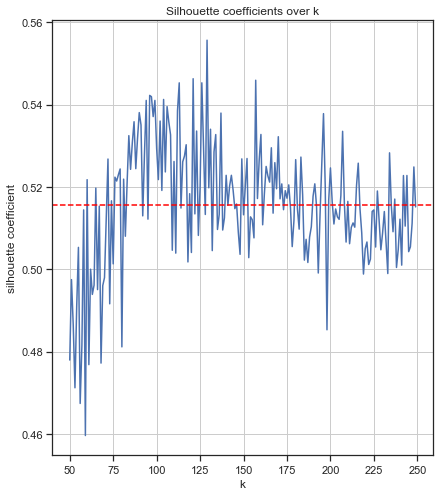

In [29]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(50, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [22]:
df_gas_mod_kmeans['labels'] = cluster_assignments

In [23]:
df_gas_mod_kmeans[0:5];

In [24]:
kmeans_ft_pca = pca.fit_transform((df_gas_mod_kmeans.iloc[:,:-1]))
df_gas_mod_kmeans['x']=kmeans_ft_pca[:,0]
df_gas_mod_kmeans['y']=kmeans_ft_pca[:,1]
df_gas_mod_kmeans['z']=kmeans_ft_pca[:,2]
pca.components_.shape

(3, 35)

In [31]:
df_gas_mod_kmeans[df_gas_mod_kmeans['labels']==17]

price base_engine_size  \
/cars/2019/ford/f-150/79212                    0.121050              3.5   
/cars/2019/ford/f-150/79217                    0.084162              3.5   
/cars/2019/ford/f-150/79218                    0.090382              3.5   
/cars/2019/ford/f-150/79224                    0.042378              3.3   
/cars/2019/ford/f-150/79225                    0.043003              3.3   
/cars/2019/ford/f-150/79236                    0.052348              3.3   
/cars/2019/ford/f-150/79237                    0.052973              3.3   
/cars/2019/gmc/canyon/78326                    0.052587              3.6   
/cars/2019/gmc/canyon/78327                    0.055504              3.6   
/cars/2019/gmc/canyon/78328                    0.065296              3.6   
/cars/2019/gmc/canyon/78329                    0.048837              3.6   
/cars/2019/gmc/canyon/78330                    0.055712              3.6   
/cars/2019/gmc/canyon/78331                    0.053212              3.6   
/cars/2019/gmc/canyon/78332                    0.056129              3.6   
/cars/2019/gmc/canyon/78333                    0.065921              3.6   
/cars/2019/gmc/canyon/78334                    0.049462              3.6   
/cars/2019/gmc/canyon/78335                    0.056337              3.6   
/cars/2019/jeep/cherokee/78548                 0.045805              3.2   
/cars/2019/jeep/cherokee/78551                 0.028825              3.2   
/cars/2019/jeep/cherokee/78554                 0.044399              3.2   
/cars/2019/jeep/cherokee/78556                 0.052743              3.2   
/cars/2019/jeep/cherokee/78558                 0.043774              3.2   
/cars/2019/jeep/cherokee/78559                 0.043774              3.2   
/cars/2019/jeep/grand-cherokee/78571           0.044243              3.6   
/cars/2019/jeep/grand-cherokee/78573           0.074974              3.6   
/cars/2019/jeep/grand-cherokee/78575           0.044243              3.6   
/cars/2019/jeep/grand-cherokee/78577           0.044243              3.6   
/cars/2019/jeep/grand-cherokee/78579           0.058723              3.6   
/cars/2019/jeep/grand-cherokee/78581           0.058723              3.6   
/cars/2019/jeep/grand-cherokee/78583           0.074974              3.6   
...                                                 ...              ...   
/cars/2019/land-rover/range-rover-velar/79540  0.110716                3   
/cars/2019/land-rover/range-rover-velar/79541  0.101549                3   
/cars/2019/nissan/frontier/79739               0.045482                4   
/cars/2019/nissan/frontier/79740               0.043295                4   
/cars/2019/nissan/frontier/79741               0.035482                4   
/cars/2019/nissan/frontier/79742               0.051025                4   
/cars/2019/nissan/frontier/79744               0.036628                4   
/cars/2019/nissan/frontier/79743               0.037503                4   
/cars/2019/nissan/frontier/79745               0.042545                4   
/cars/2019/nissan/frontier/79751               0.043899                4   
/cars/2019/nissan/frontier/79752               0.033648                4   
/cars/2019/ram/1500/78872                      0.040701              3.6   
/cars/2019/ram/1500/78886                      0.085913              3.6   
/cars/2019/ram/1500/78882                      0.091121              3.6   
/cars/2019/ram/1500/78883                      0.091746              3.6   
/cars/2019/ram/1500-classic/78854              0.040493              3.6   
/cars/2019/toyota/4runner/78940                0.068338                4   
/cars/2019/toyota/4runner/78942                0.071964                4   
/cars/2019/toyota/4runner/78944                0.050681                4   
/cars/2019/toyota/4runner/78946                0.054494                4   
/cars/2019/toyota/4runner/78947                0.053389                4   
/cars/2019/toyota/4run

In [26]:
import plotly.express as px
fig = px.scatter_3d(df_gas_mod_kmeans, x='x', y='y', z='z', color='labels')
fig.show()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



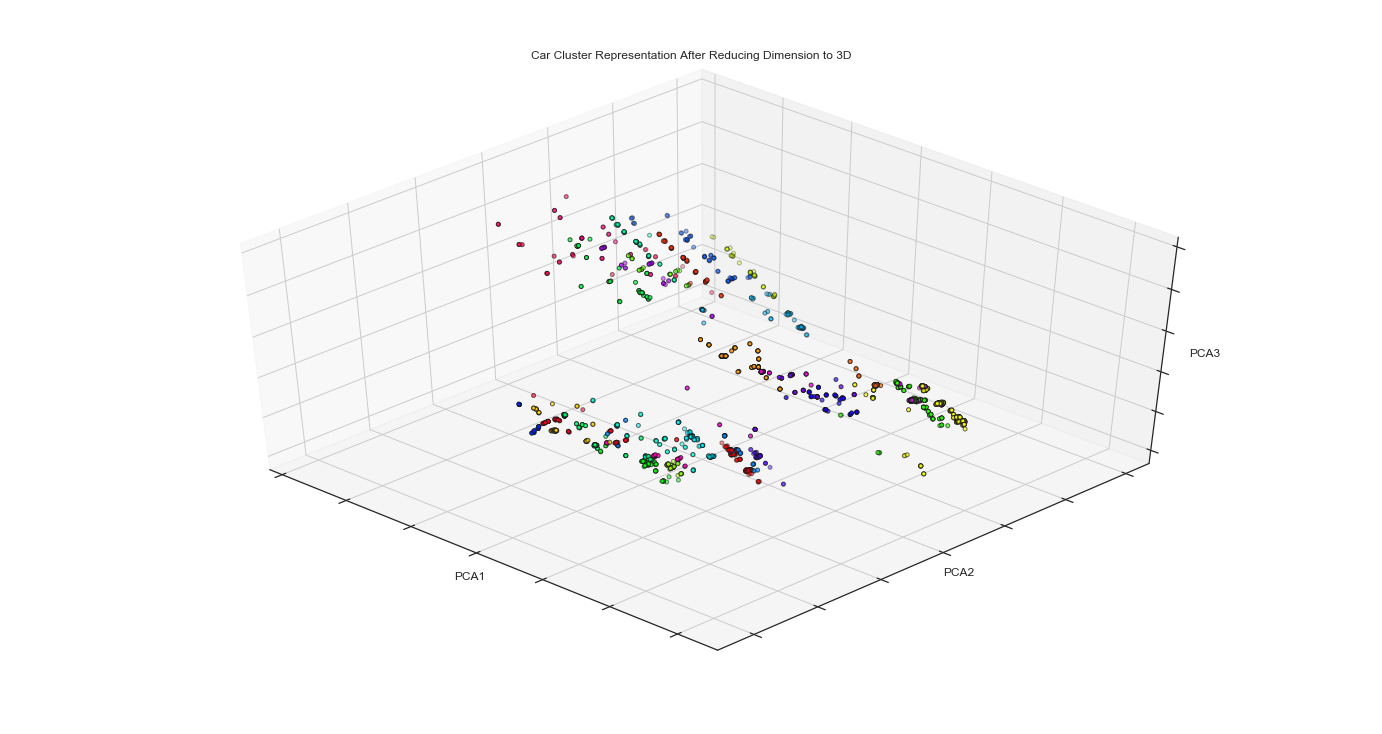

In [27]:
threed_figures(k_means, df_gas_mod_kmeans)

In [37]:
calinski_harabaz_score(df_gas_mod, labels)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning:

Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.



642.0876349837607

## AgglomerativeClustering

### Linkage = Single

In [63]:
df_gas_hac_single = df_gas_mod.copy()

In [64]:
agg_clust_single = AgglomerativeClustering(linkage='single', affinity='cosine', n_clusters=110)
assigned_clust_single = agg_clust_single.fit_predict(df_gas_hac_single)
df_gas_hac_single['labels'] = assigned_clust_single

In [48]:
# Generate silhouette coefficient for each k
X = df_gas_hac_single.copy()
silhouette_plot = []
for k in range(20, 250):
    clusters = KMeans(n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

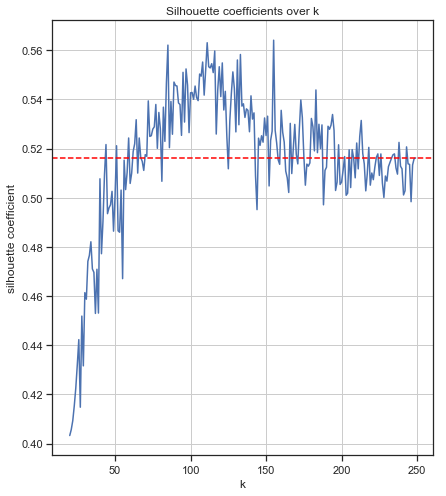

In [42]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(20, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [65]:
hac_single_ft_pca = pca.fit_transform((df_gas_hac_single.iloc[:,:-1]))
df_gas_hac_single['x']=hac_single_ft_pca[:,0]
df_gas_hac_single['y']=hac_single_ft_pca[:,1]
df_gas_hac_single['z']=hac_single_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



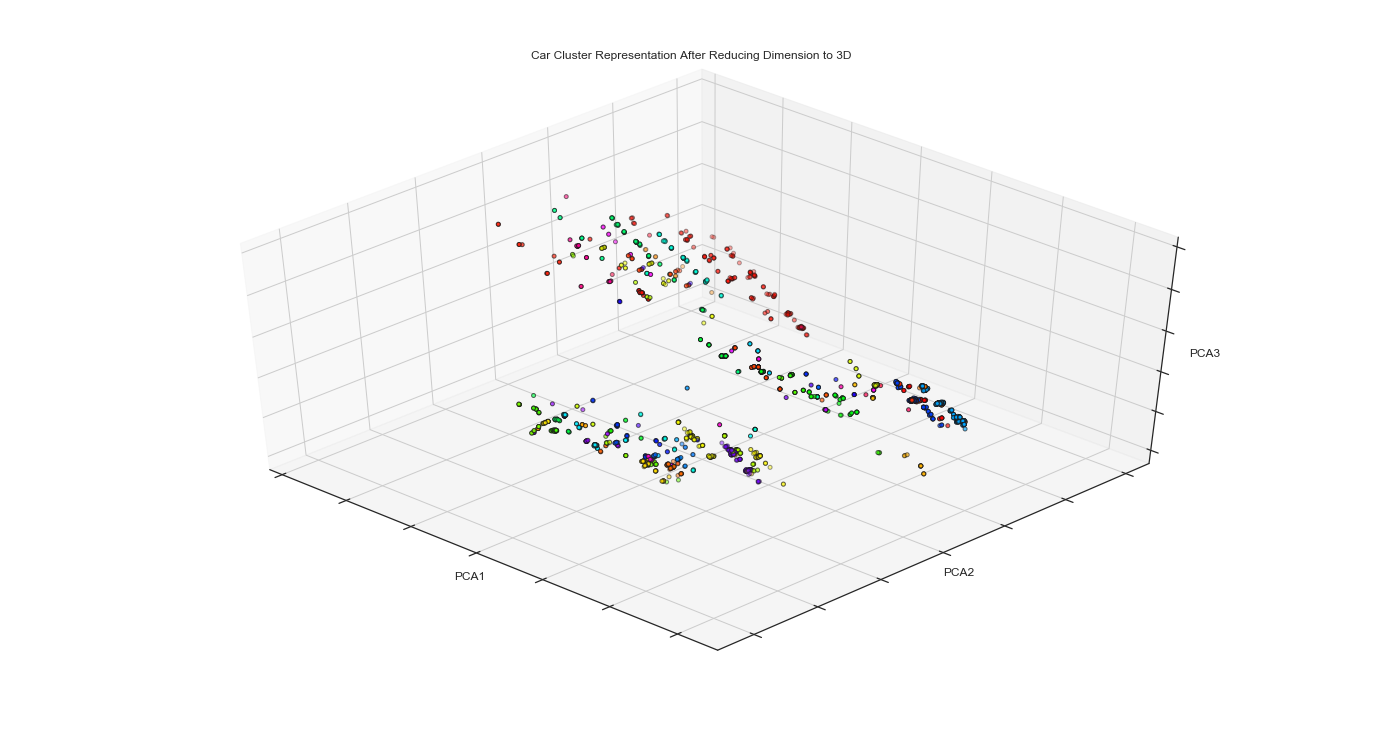

In [66]:
threed_figures(agg_clust_single, df_gas_hac_single)

### Linkage = Complete

In [67]:
df_gas_hac_complete = df_gas_mod.copy()

In [68]:
agg_clust_complete = AgglomerativeClustering(linkage='complete', affinity='cosine', n_clusters=110)
assigned_clust_complete = agg_clust_complete.fit_predict(df_gas_hac_complete)
df_gas_hac_complete['labels'] = assigned_clust_complete

In [53]:
# Generate silhouette coefficient for each k
X = df_gas_hac_complete.copy()
silhouette_plot = []
for k in range(20, 250):
    clusters = KMeans(n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

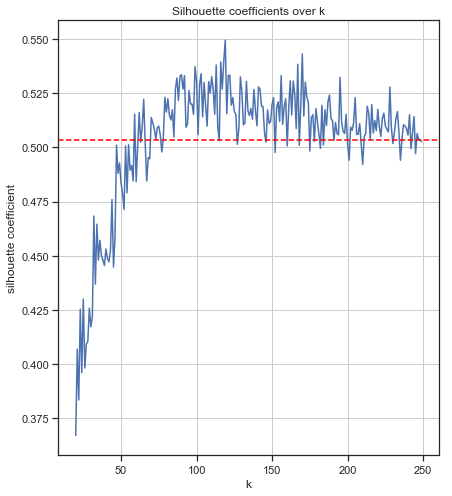

In [54]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(20, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [69]:
hac_comp_ft_pca = pca.fit_transform((df_gas_hac_complete.iloc[:,:-1]))
df_gas_hac_complete['x']=hac_comp_ft_pca[:,0]
df_gas_hac_complete['y']=hac_comp_ft_pca[:,1]
df_gas_hac_complete['z']=hac_comp_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



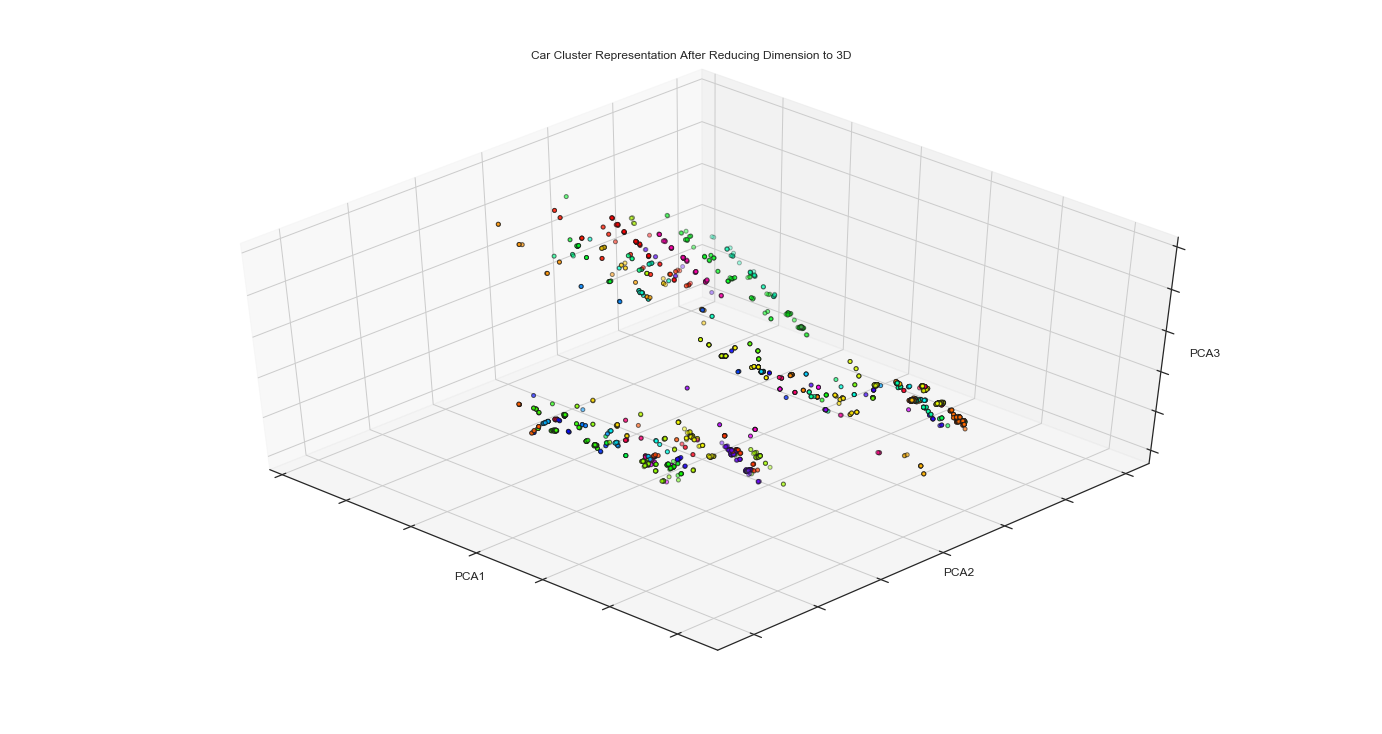

In [70]:
threed_figures(agg_clust_complete, df_gas_hac_complete)

### Linkage = Average

In [71]:
df_gas_hac_avg = df_gas_mod.copy()

In [72]:
agg_clust_avg = AgglomerativeClustering(linkage='average', affinity='cosine', n_clusters=110)
assigned_clust_avg = agg_clust_avg.fit_predict(df_gas_hac_avg)
df_gas_hac_avg['labels'] = assigned_clust_avg

In [57]:
# Generate silhouette coefficient for each k
X = df_gas_hac_avg.copy()
silhouette_plot = []
for k in range(20, 250):
    clusters = KMeans(n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

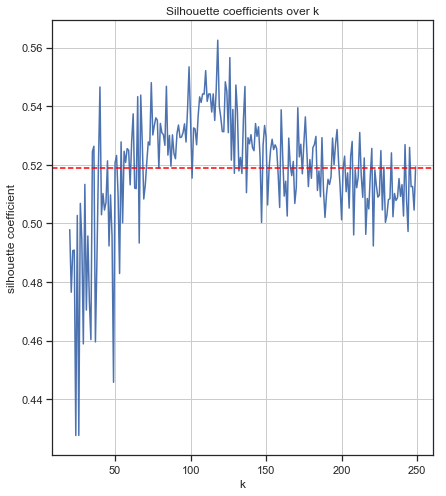

In [58]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(20, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [73]:
hac_avg_ft_pca = pca.fit_transform((df_gas_hac_avg.iloc[:,:-1]))
df_gas_hac_avg['x']=hac_avg_ft_pca[:,0]
df_gas_hac_avg['y']=hac_avg_ft_pca[:,1]
df_gas_hac_avg['z']=hac_avg_ft_pca[:,2]

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



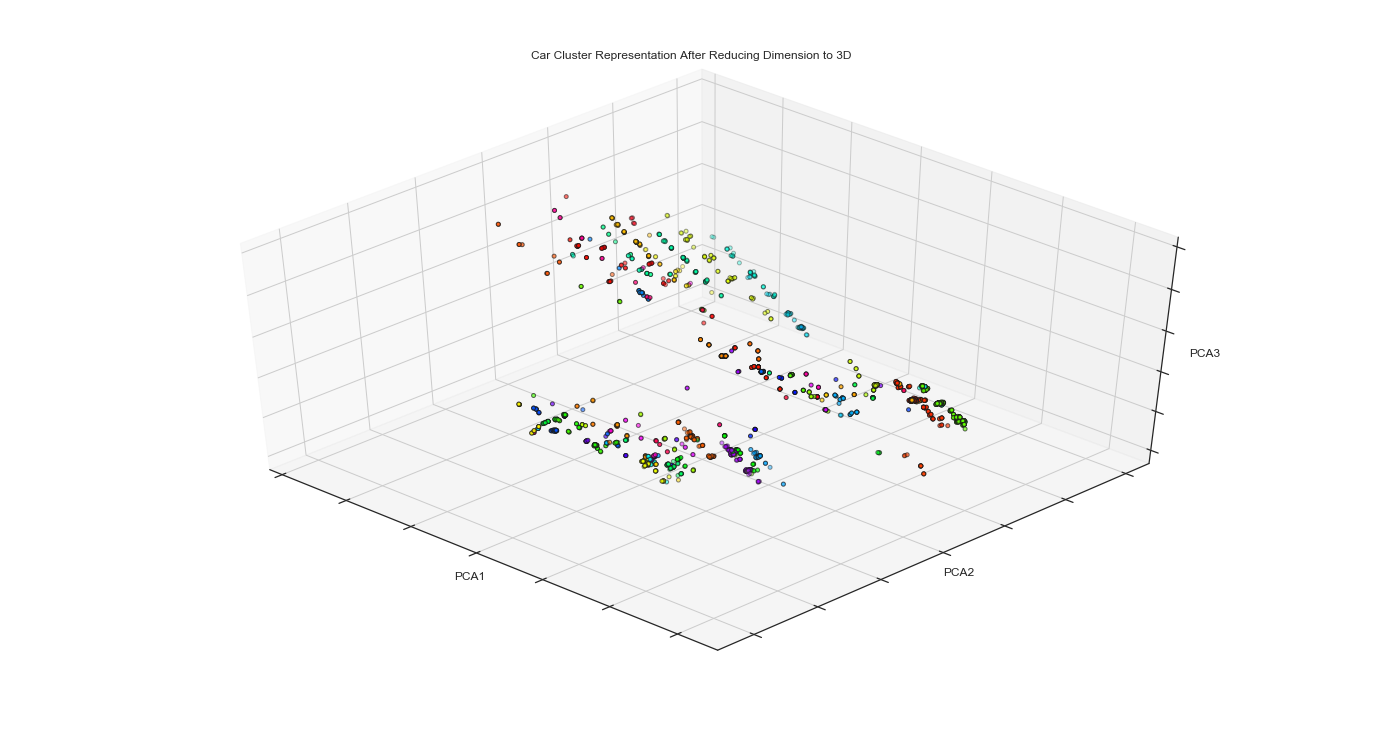

In [74]:
threed_figures(agg_clust_avg, df_gas_hac_avg)

### Linkage = Ward

In [32]:
df_gas_hac_ward = df_gas_mod.copy()

In [33]:
df_gas_hac_ward.iloc[:5,:-2];

In [34]:
agg_clust_ward = AgglomerativeClustering(linkage='ward', n_clusters=110)
assigned_clust_ward = agg_clust_ward.fit_predict(df_gas_hac_ward)
df_gas_hac_ward['labels'] = assigned_clust_ward

In [77]:
# Generate silhouette coefficient for each k
X = df_gas_hac_ward.copy()
silhouette_plot = []
for k in range(20, 250):
    clusters = AgglomerativeClustering(linkage='ward', n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

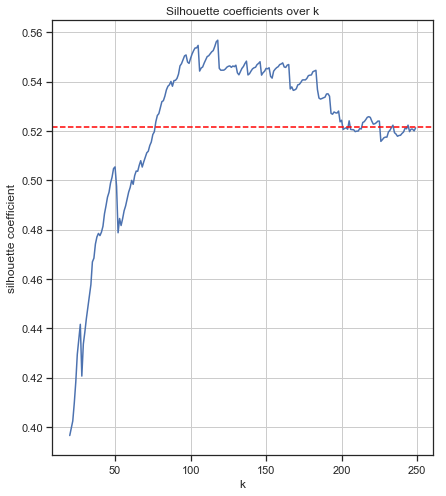

In [78]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(20, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [82]:
assigned_clust_ward

array([55, 55, 55, ..., 42, 42, 42])

In [35]:
hac_ward_ft_pca = pca.fit_transform((df_gas_hac_ward.iloc[:,:-1]))
df_gas_hac_ward['x']=hac_ward_ft_pca[:,0]
df_gas_hac_ward['y']=hac_ward_ft_pca[:,1]
df_gas_hac_ward['z']=hac_ward_ft_pca[:,2]

In [50]:
df_gas_hac_ward.loc['/cars/2019/cadillac/xt5/77895','labels']

24

In [51]:
df_gas_hac_ward[df_gas_hac_ward['labels'] == 24]

price base_engine_size  \
/cars/2019/acura/rlx/79094            0.088423              3.5   
/cars/2019/acura/tlx/77647            0.049462              3.5   
/cars/2019/acura/tlx/77644            0.063213              3.5   
/cars/2019/acura/tlx/77643            0.063213              3.5   
/cars/2019/acura/tlx/77645            0.065609              3.5   
/cars/2019/acura/tlx/77646            0.057588              3.5   
/cars/2019/buick/lacrosse/77826       0.067526              3.6   
/cars/2019/buick/lacrosse/77833       0.056067              3.6   
/cars/2019/cadillac/xt5/77895         0.060911              3.6   
/cars/2019/cadillac/xt5/77893         0.075078              3.6   
/cars/2019/cadillac/xt5/77894         0.086954              3.6   
/cars/2019/ford/taurus/78227          0.051775              3.5   
/cars/2019/ford/taurus/78228          0.031961              3.5   
/cars/2019/ford/taurus/78230          0.037024              3.5   
/cars/2019/honda/passport/79308       0.049899              3.5   
/cars/2019/honda/passport/79305       0.040690              3.5   
/cars/2019/honda/passport/79311       0.055879              3.5   
/cars/2019/honda/ridgeline/78466      0.036523              3.5   
/cars/2019/honda/ridgeline/78467      0.046691              3.5   
/cars/2019/honda/ridgeline/78470      0.051129              3.5   
/cars/2019/honda/ridgeline/78472      0.043607              3.5   
/cars/2019/jeep/cherokee/78557        0.049618              3.2   
/cars/2019/jeep/grand-cherokee/78590  0.044243              3.6   
/cars/2019/kia/cadenza/79485          0.065921              3.3   
/cars/2019/kia/cadenza/79484          0.043003              3.3   
/cars/2019/kia/cadenza/79486          0.053629              3.3   
/cars/2019/lexus/es/78656             0.065786              3.5   
/cars/2019/lexus/es/78657             0.061869              3.5   
/cars/2019/lexus/es/78652             0.056337              3.5   
/cars/2019/lexus/es/78658             0.063942              3.5   
/cars/2019/lexus/rx/78673             0.076589              3.5   
/cars/2019/lexus/rx/78674             0.064817              3.5   
/cars/2019/lincoln/continental/78684  0.119977              2.7   
/cars/2019/lincoln/continental/78686  0.070182              3.7   
/cars/2019/lincoln/continental/78688  0.098445              2.7   
/cars/2019/lincoln/continental/78690  0.078099              3.7   
/cars/2019/nissan/maxima/79767        0.060588              3.5   
/cars/2019/nissan/maxima/79766        0.044982              3.5   
/cars/2019/nissan/maxima/79768        0.054337              3.5   
/cars/2019/nissan/maxima/79769        0.056608              3.5   
/cars/2019/nissan/maxima/79770        0.049170              3.5   
/cars/2019/nissan/murano/79776        0.064942              3.5   
/cars/2019/nissan/murano/79775        0.039399              3.5   
/cars/2019/nissan/murano/79777        0.055983              3.5   
/cars/2019/nissan/murano/79778        0.046003              3.5   
/cars/2019/toyota/avalon/78958        0.061129              3.5   
/cars/2019/toyota/avalon/78959        0.061963              3.5   
/cars/2019/toyota/avalon/78960        0.048004              3.5   
/cars/2019/toyota/avalon/78961        0.053212              3.5   
/cars/2019/toyota/camry/78972         0.044982              3.5   
/cars/2019/toyota/camry/78974         0.046128              3.5   

                                      fuel_tank_capacity  \
/cars/2019/acura/rlx/79094                      0.280488   
/cars/2019/acura/tlx/77647                      0.248780   
/cars/2019/acura/tlx/77644                      0.248780   
/cars/2019/acura/tlx/77643                      0.248780   
/cars/2019/acura/tlx/77645                      0.248780   
/cars/2019/acura/tlx/77646                      0.248780   
/cars/2019/buick/lacrosse/77826                 0.214634   
/cars/2019/buick/lacrosse/77833                 0.214634   
/cars/2019/cadil

In [37]:
import plotly.express as px
fig = px.scatter_3d(df_gas_hac_ward, x='x', y='y', z='z', color='labels')
fig.show()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



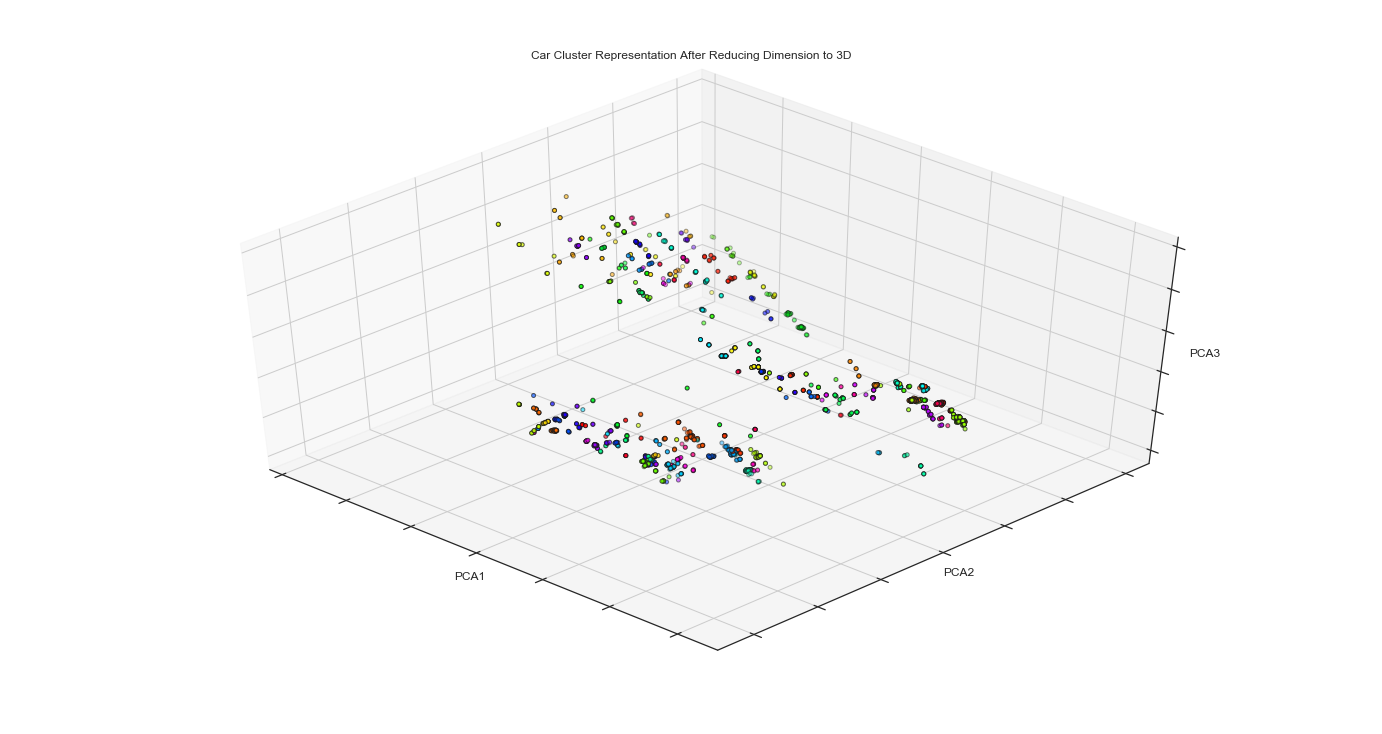

In [38]:
threed_figures(agg_clust_ward, df_gas_hac_ward)

### Dendograms, calinski_harabaz_score and silhouette_score

#### Dendograms

In [ ]:
plt.figure(figsize=(20,10))
linkage_array = single(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

In [ ]:
plt.figure(figsize=(20,10))
linkage_array = complete(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

In [ ]:
plt.figure(figsize=(20,10))
linkage_array = average(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

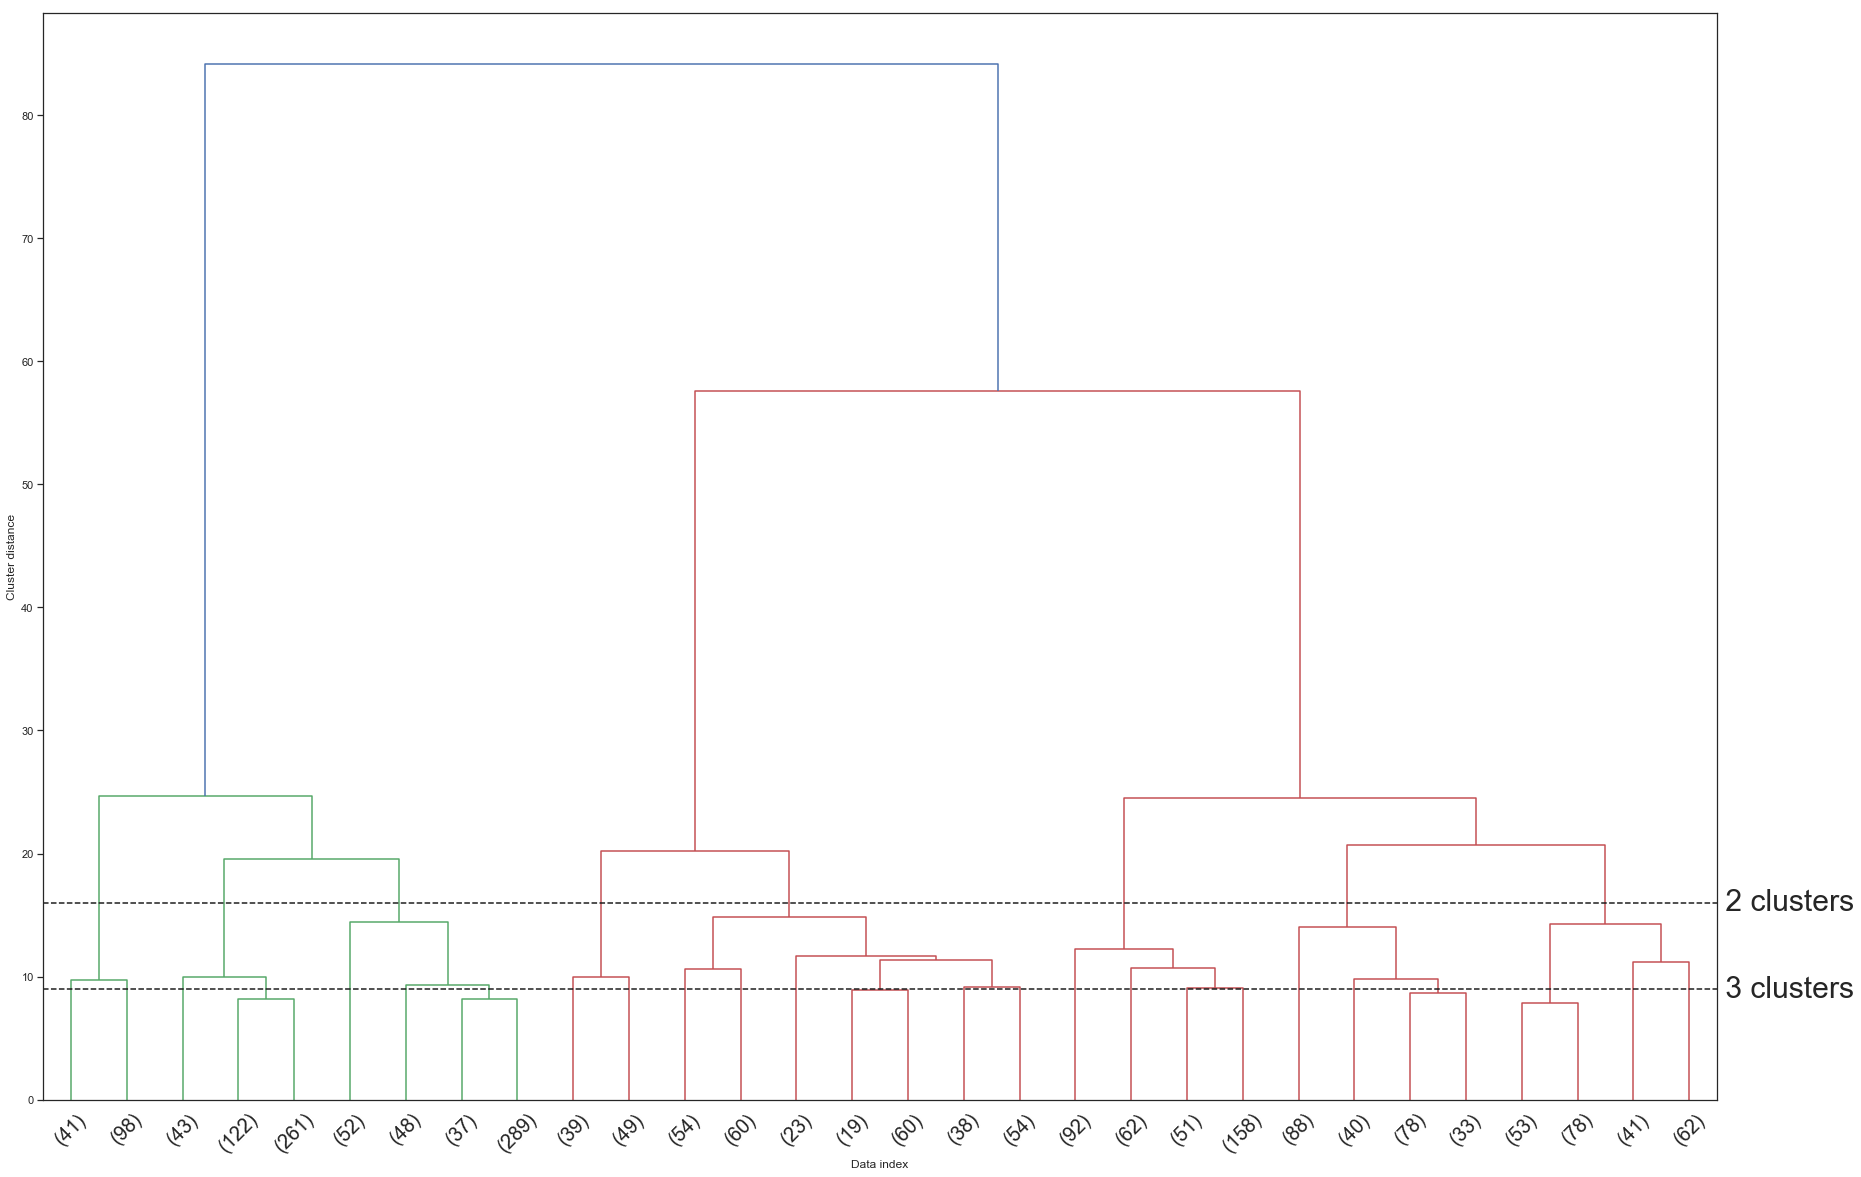

In [65]:

plt.figure(figsize=(30,20))
linkage_array = ward(df_gas_mod)

# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array,leaf_font_size=20,orientation='top',
          truncate_mode = 'lastp')

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 30})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 30})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

In [91]:
as_kmeans = k_means.fit_predict(df_gas_mod)
as_single = agg_clust_single.fit_predict(df_gas_mod)
as_comp = agg_clust_complete.fit_predict(df_gas_mod)
as_avg = agg_clust_avg.fit_predict(df_gas_mod)
as_ward = agg_clust_ward.fit_predict(df_gas_mod)

In [92]:
labels_kmeans = labels
labels_single = agg_clust_single.labels_
labels_comp = agg_clust_complete.labels_
labels_avg = agg_clust_avg.labels_
labels_ward = agg_clust_ward.labels_

#### calinski_harabasz_score

In [93]:
metrics.calinski_harabasz_score(df_gas_mod, labels_kmeans)  

642.0876349837607

In [94]:
metrics.calinski_harabasz_score(df_gas_mod,labels_single)

288.5351145641826

In [95]:
metrics.calinski_harabasz_score(df_gas_mod,labels_ward)

810.8271071906455

In [96]:
metrics.calinski_harabasz_score(df_gas_mod,labels_avg)  

428.2076357488284

In [97]:
metrics.calinski_harabasz_score(df_gas_mod,labels_comp)  

475.00389032139003

#### silhouette_score

In [98]:
metrics.silhouette_score(df_gas_mod, labels_kmeans)

0.43001681281770193

In [99]:
metrics.silhouette_score(df_gas_mod, labels_single) 

0.5440914206234837

In [100]:
metrics.silhouette_score(df_gas_mod, labels_ward) 

0.5489013298538111

In [101]:
metrics.silhouette_score(df_gas_mod,labels_avg)  

0.5774927919456233

In [102]:
metrics.silhouette_score(df_gas_mod, labels_comp)  

0.5343925354189291

Recommender

In [ ]:
df_gas_hac_ward['labels'];

In [ ]:
df_for_brands_gas[df_gas_hac_ward['labels']==0][['brand','model','Torque','price', 'Passenger Capacity', 'trim']]

In [ ]:
df_for_brands_gas[df_gas_mod_kmeans['labels']==0][['brand','model','Torque','price', 'Passenger Capacity', 'trim']]

### PCA and AgglomerativeClustering

In [ ]:
pca15 = PCA(n_components=15)
df_gas_transformed = pca15.fit_transform(df_gas_mod)

In [ ]:
pca15.explained_variance_

In [ ]:
pca15.explained_variance_ratio_

In [ ]:
np.cumsum(pca15.explained_variance_)

In [ ]:
np.cumsum(pca15.explained_variance_ratio_)

In [ ]:
plt.plot(np.cumsum(pca15.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
df_gas_transformed = pd.DataFrame(df_gas_transformed, 
                                  index=df_gas_mod.index, 
                                  columns=list(map(lambda x: 'pca'+str(x), range(1,16))))
df_gas_transformed.shape

In [ ]:
agg_clust_ward_pca = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward_pca = agg_clust_ward_pca.fit_predict(pca15.fit_transform(df_gas_transformed))

In [ ]:
df_gas_transformed['labels']=assigned_clust_ward_pca

In [ ]:
df_gas_transformed.iloc[:,:-1];

In [ ]:
df_gas_transformed

In [ ]:
metrics.silhouette_score(df_gas_transformed.iloc[:,:-1], agg_clust_ward_pca.labels_) 

In [ ]:
metrics.calinski_harabasz_score(df_gas_transformed.iloc[:,:-1], agg_clust_ward_pca.labels_) 

In [ ]:
df_for_brands_gas[df_gas_transformed['labels']==2][['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

In [ ]:
transformed_plot=df_gas_transformed.copy()

In [ ]:
pca_plot = pca.fit_transform((transformed_plot.iloc[:,:-1]))

In [ ]:
transformed_plot['x']=pca_plot[:,0]

In [ ]:
transformed_plot['y']=pca_plot[:,1]

In [ ]:
transformed_plot['z']=pca_plot[:,2]

In [ ]:
threed_figures(agg_clust_ward_pca, transformed_plot)

## Annoy

### TruncatedSVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=11)

In [ ]:
df_Annoy_svd = svd.fit_transform(df_gas_mod)

In [ ]:
print(np.cumsum(svd.explained_variance_ratio_))
print(svd.singular_values_)

In [ ]:
df_Annoy_svd.shape

In [ ]:
from annoy import AnnoyIndex

f = df_Annoy_svd.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_Annoy_svd.shape[0]):
    v = df_Annoy_svd[i]
    t.add_item(i, v)

t.build(15)
t.save('annoy_svd.ann')

In [ ]:
df_gas_mod

In [ ]:
df_gas_mod.index[100]

In [ ]:
def nearest_car_Annoy(df, car_idx, index, n, print_output=True):
    nn = index.get_nns_by_item(car_idx, n)
    if print_output == True:
        print('Closest to %s : \n' % df.index[car_idx])
    cars = [df.index[i] for i in nn]
    if print_output == True:
        return df_for_brands_gas.loc[cars, ['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

In [ ]:
def index_finder(string1,string2):
    index_list = []
    for i in df_for_brands_gas.index:
        if re.findall(str(string1).lower()+'\/'+str(string2).lower(), i):
            index_list.append(i)
    return df_for_brands_gas.loc[index_list, ['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

In [ ]:
nearest_car_Annoy(df_gas_mod, 100, t, n=20)

In [ ]:
nearest_car_Annoy(df_gas_mod, 1295, t, n=20)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(df_gas_mod)

In [ ]:
df_plot = pd.DataFrame(X_embedded, index=df_gas_mod.index, columns = ['x','y','z'])

In [ ]:
agg_clust_ward_tsne = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward_tsne = agg_clust_ward_tsne.fit_predict(df_plot)

In [ ]:
df_plot['labels']=assigned_clust_ward_tsne

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df_plot, x='x', y='y', z='z', color='labels')
fig.show()

### All Features

In [ ]:
df_gas_mod.shape

In [ ]:
from annoy import AnnoyIndex
import random

f = df_gas_mod.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_gas_mod.shape[0]):
    v = df_gas_mod.iloc[i,:]
    t.add_item(i, v)

t.build(15) # 10 trees
t.save('test.ann')

In [ ]:
nearest_car_Annoy(df_gas_mod, 90, t, n=20)

### All Features

In [ ]:
df_Annoy_pca = pca15.fit_transform(df_gas_mod)

In [ ]:
from annoy import AnnoyIndex
import random

f = df_Annoy_pca.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_Annoy_pca.shape[0]):
    v = df_Annoy_pca[i]
    t.add_item(i, v)

t.build(15) # 10 trees
t.save('test.ann')

In [ ]:
nearest_car_Annoy(df_gas_mod, 90, t, n=20)

# Function tobe Dashed

In [ ]:
val1 = input("Enter your favourite car brand: ") 
val2 = input("And model: ")
index_finder(val1,val2)

In [ ]:
val3 = input("Enter desired trim index: ") 
val3_iloc = list(df_gas_mod.index).index(str(val3))
nearest_car_Annoy(df_gas_mod, val3_iloc, t, n=20)